In [9]:
all_results = []
labels = []

In [12]:
import pandas as pd
from file_paths_and_consts import *
import os
import numpy as np
import geopandas as gpd
import math
import warnings
import time
import sys
import random
import json
warnings.filterwarnings('ignore')
#OUTPUT_DIR
## for reporducibility
calibration_it = 1
PARENT_REGION = 'Kyiv'
dir_function_type = 'constant_global_conflict_intensity_split_lagged_21_peer#Notebook_check'
dir_prefix = dir_function_type.split('#')[1]
function_type = dir_function_type.split('#')[0]
print('function type is',function_type)
Q_R = 0.00035134
V_R = 0.00053085
PEER_Q_R = 0.0008
PEER_T = 0.7
LAG = 21
#SIM = (int(sys.argv[8]) if len(sys.argv)>=9 else 11)
SIM = 11
sim_idx = str(SIM).zfill(9)
#SEED = (int(sys.argv[9]) if len(sys.argv)>=10 else 0)
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

BASE_DIR = '/project/biocomplexity/UKR_forecast/migration_data/'
geo_shp_file = BASE_DIR+'raw_data/UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'
ukr_gdf = gpd.read_file(geo_shp_file)

raion_to_dest_df = pd.read_csv('from_raion_to_dest_refugee_pdf.csv')
default_raion = raion_to_dest_df['ADM2_EN'].tolist()[0]
#print(default_raion)

USE_NEIGHBOR = 5
CONFLICT_DATA_PREFIX = 'ukraine_conflict_data_ADM2_HDX_buffer_'
NEIGHBOR_DATA_PREFIX = 'ukraine_neighbor_'
NETWORK_TYPE = '_R_0.01_P_0.04_Q_8_al_2.3.csv'
NETWORK_TYPE_fast = '_R_0.01_P_0.04_Q_8_al_2.3.pq'


total_impact_data = pd.read_csv(IMPACT_DIR+CONFLICT_DATA_PREFIX+str(USE_NEIGHBOR)+'_km.csv')

function type is constant_global_conflict_intensity_split_lagged_21_peer


In [11]:

def hazard_modeling_exponent(conflict_count,A,B):
    return A*math.exp(-B*conflict_count)

def purifier(val,abs_min=0.0000001,abs_max=0.9999999):
    return abs_min if (val<abs_min) else (abs_max if val>abs_max else val)

def calc_hazard(lmbda1,gamma,conflict_at_t,discounted_conflict,delt,function_type='constant',single_male=0,lmbda2=1,lmbdapeer=1,peer_gone=0.0,peer_thresh=1.2):
    if delt<0:
        return 0
    haz_rate = lmbda1
    if 'split' in function_type and single_male==1:
        haz_rate = lmbda2
    if ('peer' in function_type) and (peer_gone>peer_thresh):
        haz_rate = lmbdapeer
    if function_type=='constant':
        return purifier(haz_rate)
    elif function_type in ['constant_conflict','constant_global_conflict','constant_conflict_intensity','constant_global_conflict_intensity']:
        return purifier(haz_rate*(1-conflict_at_t))
    elif ('global_conflict_intensity' in function_type) and ('split' in function_type):
        return purifier(haz_rate*(1-conflict_at_t))
    elif function_type=='constant_discounted_conflict':
        return purifier(haz_rate*(1-discounted_conflict))
    elif function_type=='weibull_conflict':
        return purifier(haz_rate*gamma*(delt*(1-conflict_at_t))**(gamma-1))
    else:
        raise NotImplementedError

def sigmoid(q,v,x):
    if x<=0:
        return 0
    return 1.0 / (1 + q*math.exp(-v*x))

def get_return_prob_demographic(member_info,family_movement,non_family_movement): ##this function can be played with
    tot_size = sum(member_info)
    move_prob_family = sum([x*(1-y) for x,y in zip(member_info,family_movement)])/tot_size
    move_prob_single = sum([x*(1-y) for x,y in zip(member_info,non_family_movement)])/tot_size
    return (move_prob_family if tot_size>1 else move_prob_single)

def get_return_prob(hid,cur_time,move_date,normalized_conflict_count,member_info):
    days_passed = (cur_time-move_date).days
    time_passed_weight = sigmoid(Q_R,V_R,days_passed-1)
    conflict_observation_weight = (1-normalized_conflict_count)*get_return_prob_demographic(member_info,FAMILY_PROB,MOVE_PROB)
    #if hid==3626417:
    #    print('time passed weight',time_passed_weight)
    #    print('conflict observe weight',conflict_observation_weight)
    #    print('tot_prob',SCALE_WEIGHT*time_passed_weight*conflict_observation_weight)
    return SCALE_WEIGHT*time_passed_weight*conflict_observation_weight

def get_coin_side(prob_of_head,p):
    return 1 if p<=prob_of_head else 0


def get_refugee_file(raion_name,sim_idx):
    refugee_file_name = f'mim_hid_completed_{raion_name}_{sim_idx}.csv'
    refugee_file_name_fast = f'mim_hid_completed_{raion_name}_{sim_idx}.pq'
    hid_status_file = OUTPUT_DIR+refugee_file_name
    hid_status_file_fast = OUTPUT_DIR+refugee_file_name_fast
    if os.path.isfile(hid_status_file_fast):
        df_hid = pd.read_parquet(hid_status_file_fast)
    else:
        df_hid = pd.read_csv(hid_status_file)
        df_hid.to_parquet(hid_status_file_fast,index=False)
    df_hid = df_hid[['hid','prob_conflict','OLD_PERSON','CHILD','ADULT_MALE','ADULT_FEMALE','rlid','h_lat','h_lng',
                     'N_size','P(move|violence)','moves','move_type','move_date']]
    df_refugee = df_hid[df_hid.move_type==2]
    #print(df_hid.shape[0],'displaced from MIM simulation')
    #print(df_refugee.shape[0],'refugees from MIM simulation')
    return df_refugee

def assign_destination(df_refugee,raion_to_dest_df,raion_name):
    sci_country_code = ['HU','MDA','PL','RO','SK','BLR']
    dest_factors = ['weight_sci','weight_nato','weight_gdp','weight_gdp_per_capita','weight_dis']
    country_3_code = ['HUN','MDA','POL','ROU','SVK','BLR']

    if raion_name in raion_to_dest_df['ADM2_EN'].tolist():
        print(raion_name,'contains a prob distribution')
        dest_pdf = raion_to_dest_df[raion_to_dest_df.ADM2_EN==raion_name]
        #default_pdf['normalized_weight'] = 1.0/len(sci_country_code)
    else:
        print(raion_name,'does not exist, loading uniform distribution')
        dest_pdf = raion_to_dest_df[raion_to_dest_df.ADM2_EN==default_raion]
        dest_pdf['normalized_weight'] = 1.0/len(sci_country_code)

    dest_list = (dest_pdf.sample(df_refugee.shape[0],replace=True,weights=dest_pdf['normalized_weight'])['dest']).tolist()
    df_refugee['dest'] = dest_list
    return df_refugee



MOVE_PROB = [0.25,0.7,0.02,0.7]
FAMILY_PROB = [0.25,0.85,0.1,0.85]
#SCALE_WEIGHT = float(sys.argv[2])


# if function_type=='exponent':
#     RETURN_DIR_NAME = f'RETURN_HAZARD_{function_type}_{Q_R}_{V_R}/'
# elif function_type=='constant' or function_type=='constant_conflict' or function_type=='constant_global_conflict':
#     RETURN_DIR_NAME = f'RETURN_HAZARD_{function_type}_{Q_R}/'
# elif function_type=='weibull_conflict' or function_type=='constant_discounted_conflict':
#     RETURN_DIR_NAME = f'RETURN_HAZARD_{function_type}_{Q_R}_{V_R}/'
# else:
#     raise NotImplementedError
RETURN_DIR_NAME = f'RETURN_HAZARD_{dir_prefix}_{function_type}_{str(calibration_it).zfill(9)}/'

if not os.path.isdir(OUTPUT_DIR+RETURN_DIR_NAME):
    os.makedirs(OUTPUT_DIR+RETURN_DIR_NAME)

with open('raion_partitions_10.json') as f_in:
    REGION_BIN_DICT = json.load(f_in)
        
ALL_RAION_BINS = [PARENT_REGION]+REGION_BIN_DICT[PARENT_REGION]
print('will process the raions:',ALL_RAION_BINS,flush=True)

##more optimized code
## return_prob is calculated without the function

print('Simulation Parameters','region:',PARENT_REGION,'hazard function type:',function_type,'Scale: ',Q_R,'Rate: ',V_R,'SEED: ',SEED,'ABSCIM SIM:',sim_idx)

will process the raions: ['Kyiv', 'Khersonskyi', 'Haisynskyi', 'Umanskyi', 'Sambirskyi', 'Oleksandriiskyi', 'Bilhorod-Dnistrovskyi', 'Novoukrainskyi', 'Berdychivskyi', 'Pervomaiskyi', 'Krasnohradskyi', 'Rozdilnianskyi', 'Verkhovynskyi']
Simulation Parameters region: Kyiv hazard function type: constant_global_conflict_intensity_split_lagged_21_peer Scale:  0.00035134 Rate:  0.00053085 SEED:  0 ABSCIM SIM: 000000011


In [16]:
for pp in [0.87,0.89,0.9,1.2]:
    PEER_T = pp
    for raion_name in ALL_RAION_BINS[0:1]:
        try:
            # if os.path.isfile(OUTPUT_DIR+RETURN_DIR_NAME+f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_{SEED}.pq'):
            #     print('already simulated for',raion_name,sim_idx,flush=True)
            #     continue
            # else:
            #     print('file does not exist',OUTPUT_DIR+RETURN_DIR_NAME+f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_{SEED}.pq','... will simulate now..')
            returned_refugees = []
            st_time = time.time()

            if os.path.isfile(HOUSEHOLD_DIR+'KSW_HH_BALL_AAMAS_'+raion_name+NETWORK_TYPE_fast):
                print('KSW neighborhood loaded')
                neighbor_household_data = pd.read_parquet(HOUSEHOLD_DIR+'KSW_HH_BALL_AAMAS_'+raion_name+NETWORK_TYPE_fast)
            elif os.path.isfile(HOUSEHOLD_DIR+'KSW_HH_BALL_AAMAS_'+raion_name+NETWORK_TYPE):
                print('KSW neighborhood loaded')
                neighbor_household_data = pd.read_csv(HOUSEHOLD_DIR+'KSW_HH_BALL_AAMAS_'+raion_name+NETWORK_TYPE)
                neighbor_household_data.to_parquet(HOUSEHOLD_DIR+'KSW_HH_BALL_AAMAS_'+raion_name+NETWORK_TYPE_fast,index=False)
            else:
                print('s2 neighborhood loaded')
                neighbor_household_data = pd.read_csv(HOUSEHOLD_DIR+NEIGHBOR_DATA_PREFIX+raion_name+'_13_s2.csv',usecols=['hid_x','hid_y'])

            df_refugee = get_refugee_file(raion_name,sim_idx)
            df_refugee = assign_destination(df_refugee,raion_to_dest_df,raion_name)
            df_refugee['origin'] = raion_name

            START_DATE = '2022-02-24'
            END_DATE = '2022-09-01'
            T_CURRENT = pd.to_datetime(START_DATE)
            T_FINAL = pd.to_datetime(END_DATE)
            NO_RETURN_DATE = pd.to_datetime('2025-01-01')

            if 'global_conflict' not in function_type:
                impact_data = total_impact_data[total_impact_data.matching_place_id==raion_name]
            else:
                print('looking at whole UKR')
                impact_data = total_impact_data

            impact_data['time'] = pd.to_datetime(impact_data['time'])
            if 'intensity' not in function_type:
                print('working based on count')
                conflict_context = impact_data.groupby('time')['event_id'].count().reset_index()
                conflict_context = conflict_context.rename(columns={'event_id':'conflict'})
            else:
                print('working based on intensity')
                conflict_context = impact_data.groupby('time')['event_intensity'].sum().reset_index()
                conflict_context = conflict_context.rename(columns={'event_intensity':'conflict'})

            conflict_context['conflict'] = conflict_context['conflict'].rolling(14).mean()
            conflict_context = conflict_context.dropna(subset='conflict')
            NORM_CONSTANT = conflict_context['conflict'].max()
            conflict_context['conflict'] = conflict_context['conflict']/NORM_CONSTANT

            print(df_refugee.columns.tolist())
            df_refugee['h_size'] = df_refugee[DEMO_TYPES].sum(axis=1)
            df_refugee['single_male'] = df_refugee.apply(lambda x: (1 if (x['ADULT_MALE']==1 and x['h_size']==1) else 0),axis=1)
            print(df_refugee[df_refugee.single_male==1].shape[0],'is single male hh out of',df_refugee.shape[0])
            df_refugee['move_date'] = pd.to_datetime(df_refugee['move_date'])
            df_refugee['return_date'] = pd.to_datetime('2025-01-01')
            df_refugee['demo_move_prob'] = df_refugee.apply(lambda x: get_return_prob_demographic(x[DEMO_TYPES].tolist(),FAMILY_PROB,MOVE_PROB),axis=1)
            df_refugee['survival_prob'] = 1.0

            hid_nsize = (neighbor_household_data.groupby('hid_x')['hid_y'].count().reset_index()).rename(columns={'hid_x':'hid','hid_y':'n_size'})
            refugee_nsizes_total = hid_nsize.merge(df_refugee[['hid']],on='hid',how='inner')
            refugee_neighborhood_only = neighbor_household_data.merge(df_refugee[['hid']],left_on='hid_x',right_on='hid',how='inner')
            refugee_neighborhood_only = refugee_neighborhood_only.drop(columns=['hid'])
            refugee_neighborhood_only = refugee_neighborhood_only.merge(df_refugee[['hid']],left_on='hid_y',right_on='hid',how='inner')
            refugee_neighborhood_only = refugee_neighborhood_only.drop(columns=['hid'])#contains edge where both vertices are refugee
            refugee_nsizes_outside = (refugee_neighborhood_only.groupby('hid_x')['hid_y'].count().reset_index()).rename(columns={'hid_x':'hid','hid_y':'n_size_migrant'})
            neighbor_effect_df = refugee_nsizes_outside.merge(refugee_nsizes_total,on='hid',how='inner')
            neighbor_effect_df['peer_return_fraction'] = (neighbor_effect_df['n_size']-neighbor_effect_df['n_size_migrant'])/neighbor_effect_df['n_size']

            print('simulation starting...')
            prev_impact_count = 0
            for i in range(0,300):
                #print(T_CURRENT)
                if T_CURRENT > T_FINAL:
                    break
                sim_start = time.time()

                if 'lagged' not in function_type:
                    print('taking current')
                    cur_conflict_context = conflict_context[conflict_context.time==T_CURRENT]
                else:
                    print('taking lag of',LAG)
                    cur_conflict_context = conflict_context[conflict_context.time==(T_CURRENT-pd.DateOffset(days=LAG))]

                cur_impact_count = 0 if cur_conflict_context.shape[0]==0 else max(cur_conflict_context['conflict'])
                print('at',T_CURRENT,'conflict context is',cur_impact_count)
                #tot_count = impact_data.shape[0]
                normalized_impact_count = cur_impact_count
                discounted_impact_count = min(1.0,prev_impact_count*V_R + normalized_impact_count)

                ret_module_start = time.time()
                #approach 1: takes 80 seconds
                #df_refugee['return_prob'] = df_refugee.apply(lambda x: get_return_prob(x['hid'],T_CURRENT,x['move_date'],normalized_impact_count,x[DEMO_TYPES].tolist()),axis=1)

                #approach 2: takes -- seconds
                df_refugee['days_passed'] = (T_CURRENT-df_refugee['move_date']).dt.days
                #df_refugee['sigmoid_days_passed'] = 1.0/(1+Q_R*np.exp(-V_R*(df_refugee['days_passed']-1)))
                #df_refugee['valid_day'] = df_refugee['days_passed'].apply(lambda x: 1 if x>=1 else 0)
                #df_refugee['time_weight'] = df_refugee['valid_day']*df_refugee['sigmoid_days_passed']
                df_refugee = df_refugee.merge(neighbor_effect_df[['hid','peer_return_fraction']],on='hid',how='inner')

                print('average peer return fraction is',df_refugee['peer_return_fraction'].mean())

                if 'split' not in function_type:
                    df_refugee['hazard'] = df_refugee.apply(lambda x: calc_hazard(Q_R,V_R,normalized_impact_count,discounted_impact_count,
                                                                                  x['days_passed'],function_type=function_type,lmbdapeer=PEER_Q_R,
                                                                                  peer_gone=x['peer_return_fraction'],peer_thresh=PEER_T), axis = 1)
                else:
                    print('assigning a different haz rate of',V_R,'to single male houses')
                    df_refugee['hazard'] = df_refugee.apply(lambda x: calc_hazard(Q_R,V_R,normalized_impact_count,discounted_impact_count,x['days_passed'],
                                                                                  function_type=function_type,single_male=x['single_male'],lmbda2=V_R,lmbdapeer=PEER_Q_R,
                                                                                  peer_gone=x['peer_return_fraction'],peer_thresh=PEER_T), axis = 1)
                #df_refugee['hazard'] = df_refugee['hazard'].apply(lambda x: 0.00001 if x<0.00001 else (0.99999 if x>0.99999 else x))
                df_refugee['survival_prob'] = df_refugee['survival_prob']*(1.0-df_refugee['hazard'])
                df_refugee['return_prob'] = 1-df_refugee['survival_prob']
                #df_refugee['return_prob'] = SCALE_WEIGHT*df_refugee['time_weight']*(1-normalized_impact_count)*df_refugee['demo_move_prob']*df_refugee['peer_return_fraction']
                #df_refugee['return_prob'] = SCALE_WEIGHT*df_refugee['time_weight']*(1-normalized_impact_count)*df_refugee['demo_move_prob']
                #df_refugee = df_refugee.drop(columns=['days_passed','sigmoid_days_passed','valid_day','time_weight'])
                df_refugee = df_refugee.drop(columns=['days_passed'])

                ret_module_end = time.time()
                #print(T_CURRENT,'return module calculated in',ret_module_end-ret_module_start,'seconds with pop size',df_refugee.shape[0])

                coin_toss_start = time.time()
                df_refugee['coin_toss'] = np.random.random(df_refugee.shape[0])
                #print(T_CURRENT,'coin toss done in',time.time()-coin_toss_start,'seconds with pop size',df_refugee.shape[0])

                coin_sample_start = time.time()
                df_refugee['return'] = df_refugee.apply(lambda x: get_coin_side(x['return_prob'],x['coin_toss']),axis=1)
                #print(T_CURRENT,'coin side sampled in',time.time()-coin_sample_start,'seconds with pop size',df_refugee.shape[0])

                date_assigned_start = time.time()
                df_refugee['return_date'] = df_refugee['return'].apply(lambda x: T_CURRENT if x==1 else NO_RETURN_DATE)
                #print(T_CURRENT,'return date assigned in',time.time()-date_assigned_start,'seconds with pop size',df_refugee.shape[0])

                split_start = time.time()
                returned_refugees.append(df_refugee[df_refugee['return']==1])
                print(T_CURRENT,df_refugee[df_refugee['return']==1].shape[0],'refugee returned','time taken:',time.time()-sim_start,flush=True)
                df_refugee = df_refugee[df_refugee['return']==0]
                #print(T_CURRENT,'dataset split in',time.time()-split_start,'seconds with remaining pop size',df_refugee.shape[0])
                #print(df_refugee[['hid','return_prob']])

                refugee_neighborhood_only = refugee_neighborhood_only.merge(df_refugee[['hid']],left_on='hid_x',right_on='hid',how='inner')
                refugee_neighborhood_only = refugee_neighborhood_only.drop(columns=['hid'])
                refugee_neighborhood_only = refugee_neighborhood_only.merge(df_refugee[['hid']],left_on='hid_y',right_on='hid',how='inner')
                refugee_neighborhood_only = refugee_neighborhood_only.drop(columns=['hid'])
                refugee_nsizes_outside = (refugee_neighborhood_only.groupby('hid_x')['hid_y'].count().reset_index()).rename(columns={'hid_x':'hid','hid_y':'n_size_migrant'})
                neighbor_effect_df = neighbor_effect_df.drop(columns=['n_size_migrant'])
                neighbor_effect_df = refugee_nsizes_outside.merge(neighbor_effect_df,on='hid',how='inner')
                neighbor_effect_df['peer_return_fraction'] = (neighbor_effect_df['n_size']-neighbor_effect_df['n_size_migrant'])/neighbor_effect_df['n_size']
                df_refugee =  df_refugee.drop(columns=['peer_return_fraction'])

                T_CURRENT = T_CURRENT + pd.DateOffset(days=1)
                prev_impact_count = discounted_impact_count
            print(raion_name,'simulated in',time.time()-st_time,'seconds',flush=True)
            #pd.concat(returned_refugees).to_csv(OUTPUT_DIR+RETURN_DIR_NAME+f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_{SEED}.csv',index=False)
            pd.concat(returned_refugees).to_parquet(OUTPUT_DIR+RETURN_DIR_NAME+f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_{SEED}.pq',index=False)
        except Exception as e:
            print(e)
            continue
    all_results.append(pd.concat(returned_refugees))
    labels.append(f'peer-{PEER_T}')

KSW neighborhood loaded
Kyiv contains a prob distribution
looking at whole UKR
working based on intensity
['hid', 'prob_conflict', 'OLD_PERSON', 'CHILD', 'ADULT_MALE', 'ADULT_FEMALE', 'rlid', 'h_lat', 'h_lng', 'N_size', 'P(move|violence)', 'moves', 'move_type', 'move_date', 'dest', 'origin']
397 is single male hh out of 274233
simulation starting...
taking lag of 21
at 2022-02-24 00:00:00 conflict context is 0
average peer return fraction is 0.5726648429699909
assigning a different haz rate of 0.00053085 to single male houses
2022-02-24 00:00:00 7 refugee returned time taken: 4.768845081329346
taking lag of 21
at 2022-02-25 00:00:00 conflict context is 0
average peer return fraction is 0.57267707990213
assigning a different haz rate of 0.00053085 to single male houses
2022-02-25 00:00:00 13 refugee returned time taken: 4.759108304977417
taking lag of 21
at 2022-02-26 00:00:00 conflict context is 0
average peer return fraction is 0.5726938878204854
assigning a different haz rate of 0.00

In [3]:
df1 = pd.read_csv('exp-1.csv')
df2 = pd.read_csv('exp-2.csv')
all_results.append(df1)
all_results.append(df2)
labels.append('peer-0.9')
labels.append('peer-0.7')

In [4]:
# all_results.append(pd.concat(returned_refugees))
# labels.append('peer-0.9')

In [5]:
#all_results[0].to_csv('exp-1.csv')
#all_results[1].to_csv('exp-2.csv')

In [17]:
print(len(all_results))
print(len(labels))

8
8


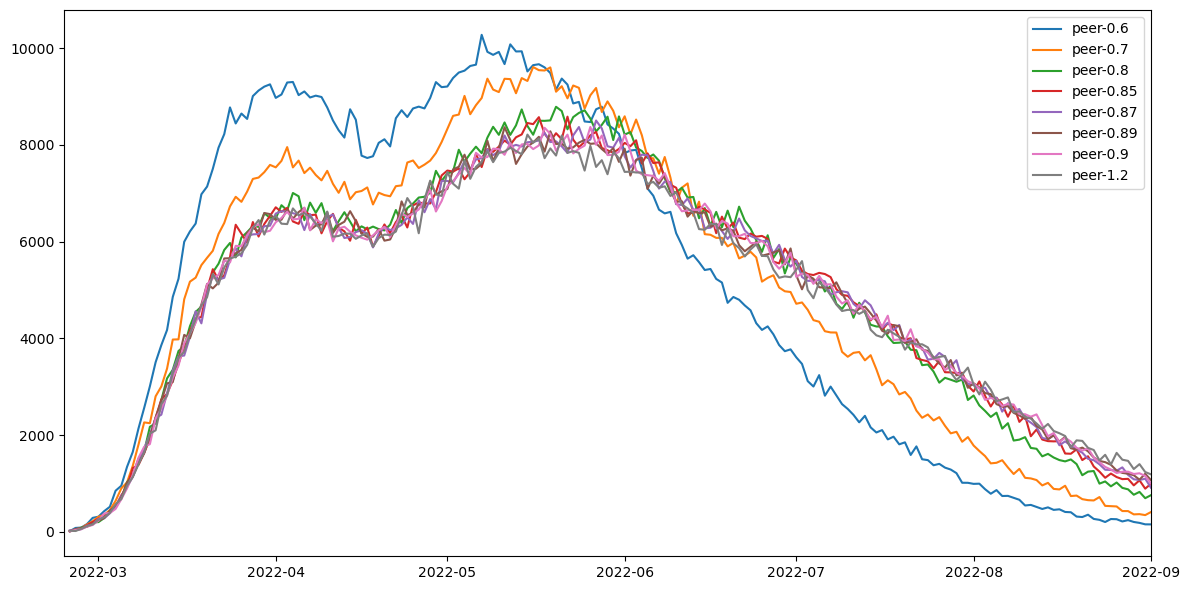

In [18]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,6))

for idx,df in enumerate(all_results):
    df['return_date'] = pd.to_datetime(df['return_date'])
    df['h_size'] = df[DEMO_TYPES].sum(axis=1)
    return_df = df.groupby('return_date')['h_size'].sum().reset_index()
    return_df['h_size'] = return_df['h_size'].rolling(1).mean()
    return_df = return_df.dropna(subset=['h_size'])
    #all_dfs.append(return_df)
    ax.plot(return_df['return_date'],return_df['h_size'],label=labels[idx])

# ax2 = ax.twinx()
# ax2.plot(local_impact_data_cnt['time'],local_impact_data_cnt['event_id'],label='local')
# ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['event_id'],label='global')
ax.set_xlim([pd.to_datetime('2022-02-23'),pd.to_datetime('2022-09-01')])
ax.legend(loc='best')
#ax2.legend(loc='lower right')
fig.tight_layout()

In [6]:


for single_male_rate in [0.1,0.01,0.001]:

    calibration_it = 15
    PARENT_REGION = 'Kyiv'
    dir_function_type = f'constant_global_conflict_intensity_split_{single_male_rate}#Notebook_Check'
    dir_prefix = dir_function_type.split('#')[1]
    function_type = dir_function_type.split('#')[0]
    print('function type is',function_type)
    label = f'single_male_{single_male_rate}_q_GC_calibrated'
    Q_R = 0.000346
    V_R = single_male_rate
    SIM = 11
    sim_idx = str(SIM).zfill(9)
    SEED = 1
    random.seed(SEED)
    np.random.seed(SEED)

    BASE_DIR = '/project/biocomplexity/UKR_forecast/migration_data/'
    geo_shp_file = BASE_DIR+'raw_data/UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'
    ukr_gdf = gpd.read_file(geo_shp_file)

    raion_to_dest_df = pd.read_csv('from_raion_to_dest_refugee_pdf.csv')
    default_raion = raion_to_dest_df['ADM2_EN'].tolist()[0]
    #print(default_raion)

    USE_NEIGHBOR = 5
    CONFLICT_DATA_PREFIX = 'ukraine_conflict_data_ADM2_HDX_buffer_'
    NEIGHBOR_DATA_PREFIX = 'ukraine_neighbor_'
    NETWORK_TYPE = '_R_0.01_P_0.04_Q_8_al_2.3.csv'
    NETWORK_TYPE_fast = '_R_0.01_P_0.04_Q_8_al_2.3.pq'


    total_impact_data = pd.read_csv(IMPACT_DIR+CONFLICT_DATA_PREFIX+str(USE_NEIGHBOR)+'_km.csv')

    MOVE_PROB = [0.25,0.7,0.02,0.7]
    FAMILY_PROB = [0.25,0.85,0.1,0.85]
    #SCALE_WEIGHT = float(sys.argv[2])

    RETURN_DIR_NAME = f'RETURN_HAZARD_{dir_prefix}_{function_type}_{str(calibration_it).zfill(9)}/'

    if not os.path.isdir(OUTPUT_DIR+RETURN_DIR_NAME):
        os.makedirs(OUTPUT_DIR+RETURN_DIR_NAME)

    with open('raion_partitions_10.json') as f_in:
        REGION_BIN_DICT = json.load(f_in)

    ALL_RAION_BINS = [PARENT_REGION]+REGION_BIN_DICT[PARENT_REGION]
    print('will process the raions:',ALL_RAION_BINS,flush=True)

    ##more optimized code
    ## return_prob is calculated without the function

    print('Simulation Parameters','region:',PARENT_REGION,'hazard function type:',function_type,'Scale: ',Q_R,'Rate: ',V_R,'SEED: ',SEED,'ABSCIM SIM:',sim_idx)
    
    for raion_name in ALL_RAION_BINS[0:1]:

        # if os.path.isfile(OUTPUT_DIR+RETURN_DIR_NAME+f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_{SEED}.pq'):
        #     print('already simulated for',raion_name,sim_idx,flush=True)
        #     continue
        # else:
        #     print('file does not exist',OUTPUT_DIR+RETURN_DIR_NAME+f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_{SEED}.pq','... will simulate now..')
        returned_refugees = []
        st_time = time.time()

        if os.path.isfile(HOUSEHOLD_DIR+'KSW_HH_BALL_AAMAS_'+raion_name+NETWORK_TYPE_fast):
            print('KSW neighborhood loaded')
            neighbor_household_data = pd.read_parquet(HOUSEHOLD_DIR+'KSW_HH_BALL_AAMAS_'+raion_name+NETWORK_TYPE_fast)
        elif os.path.isfile(HOUSEHOLD_DIR+'KSW_HH_BALL_AAMAS_'+raion_name+NETWORK_TYPE):
            print('KSW neighborhood loaded')
            neighbor_household_data = pd.read_csv(HOUSEHOLD_DIR+'KSW_HH_BALL_AAMAS_'+raion_name+NETWORK_TYPE)
            neighbor_household_data.to_parquet(HOUSEHOLD_DIR+'KSW_HH_BALL_AAMAS_'+raion_name+NETWORK_TYPE_fast,index=False)
        else:
            print('s2 neighborhood loaded')
            neighbor_household_data = pd.read_csv(HOUSEHOLD_DIR+NEIGHBOR_DATA_PREFIX+raion_name+'_13_s2.csv',usecols=['hid_x','hid_y'])

        df_refugee = get_refugee_file(raion_name,sim_idx)
        df_refugee = assign_destination(df_refugee,raion_to_dest_df,raion_name)
        df_refugee['origin'] = raion_name

        START_DATE = '2022-02-24'
        END_DATE = '2022-07-15'
        T_CURRENT = pd.to_datetime(START_DATE)
        T_FINAL = pd.to_datetime(END_DATE)
        NO_RETURN_DATE = pd.to_datetime('2025-01-01')

        if 'global_conflict' not in function_type:
            impact_data = total_impact_data[total_impact_data.matching_place_id==raion_name]
        else:
            print('looking at whole UKR')
            impact_data = total_impact_data

        impact_data['time'] = pd.to_datetime(impact_data['time'])
        if 'intensity' not in function_type:
            print('working based on count')
            conflict_context = impact_data.groupby('time')['event_id'].count().reset_index()
            conflict_context = conflict_context.rename(columns={'event_id':'conflict'})
        else:
            print('working based on intensity')
            conflict_context = impact_data.groupby('time')['event_intensity'].sum().reset_index()
            conflict_context = conflict_context.rename(columns={'event_intensity':'conflict'})

        conflict_context['conflict'] = conflict_context['conflict'].rolling(14).mean()
        conflict_context = conflict_context.dropna(subset='conflict')
        NORM_CONSTANT = conflict_context['conflict'].max()
        conflict_context['conflict'] = conflict_context['conflict']/NORM_CONSTANT
        
        print(df_refugee.columns.tolist())
        df_refugee['h_size'] = df_refugee[DEMO_TYPES].sum(axis=1)
        df_refugee['single_male'] = df_refugee.apply(lambda x: (1 if (x['ADULT_MALE']==1 and x['h_size']==1) else 0),axis=1)
        print(df_refugee[df_refugee.single_male==1].shape[0],'is single male hh out of',df_refugee.shape[0])
        df_refugee['move_date'] = pd.to_datetime(df_refugee['move_date'])
        df_refugee['return_date'] = pd.to_datetime('2025-01-01')
        df_refugee['demo_move_prob'] = df_refugee.apply(lambda x: get_return_prob_demographic(x[DEMO_TYPES].tolist(),FAMILY_PROB,MOVE_PROB),axis=1)
        df_refugee['survival_prob'] = 1.0

        hid_nsize = (neighbor_household_data.groupby('hid_x')['hid_y'].count().reset_index()).rename(columns={'hid_x':'hid','hid_y':'n_size'})
        refugee_nsizes_total = hid_nsize.merge(df_refugee[['hid']],on='hid',how='inner')
        refugee_neighborhood_only = neighbor_household_data.merge(df_refugee[['hid']],left_on='hid_x',right_on='hid',how='inner')
        refugee_neighborhood_only = refugee_neighborhood_only.drop(columns=['hid'])
        refugee_neighborhood_only = refugee_neighborhood_only.merge(df_refugee[['hid']],left_on='hid_y',right_on='hid',how='inner')
        refugee_neighborhood_only = refugee_neighborhood_only.drop(columns=['hid'])
        refugee_nsizes_outside = (refugee_neighborhood_only.groupby('hid_x')['hid_y'].count().reset_index()).rename(columns={'hid_x':'hid','hid_y':'n_size_migrant'})
        neighbor_effect_df = refugee_nsizes_outside.merge(refugee_nsizes_total,on='hid',how='inner')
        neighbor_effect_df['peer_return_fraction'] = (neighbor_effect_df['n_size']-neighbor_effect_df['n_size_migrant'])/neighbor_effect_df['n_size']

        print('simulation starting...')
        prev_impact_count = 0
        for i in range(0,300):
            #print(T_CURRENT)
            if T_CURRENT > T_FINAL:
                break
            sim_start = time.time()

            if 'lagged' not in function_type:
                print('taking current')
                cur_conflict_context = conflict_context[conflict_context.time==T_CURRENT]
            else:
                print('taking lag of',V_R)
                cur_conflict_context = conflict_context[conflict_context.time==(T_CURRENT-pd.DateOffset(days=(int(V_R))))]

            cur_impact_count = 0 if cur_conflict_context.shape[0]==0 else max(cur_conflict_context['conflict'])
            print('at',T_CURRENT,'conflict context is',cur_impact_count)
            #tot_count = impact_data.shape[0]
            normalized_impact_count = cur_impact_count
            discounted_impact_count = min(1.0,prev_impact_count*V_R + normalized_impact_count)

            ret_module_start = time.time()
            #approach 1: takes 80 seconds
            #df_refugee['return_prob'] = df_refugee.apply(lambda x: get_return_prob(x['hid'],T_CURRENT,x['move_date'],normalized_impact_count,x[DEMO_TYPES].tolist()),axis=1)

            #approach 2: takes -- seconds
            df_refugee['days_passed'] = (T_CURRENT-df_refugee['move_date']).dt.days
            #df_refugee['sigmoid_days_passed'] = 1.0/(1+Q_R*np.exp(-V_R*(df_refugee['days_passed']-1)))
            #df_refugee['valid_day'] = df_refugee['days_passed'].apply(lambda x: 1 if x>=1 else 0)
            #df_refugee['time_weight'] = df_refugee['valid_day']*df_refugee['sigmoid_days_passed']
            df_refugee = df_refugee.merge(neighbor_effect_df[['hid','peer_return_fraction']],on='hid',how='inner')

            if 'split' not in function_type:
                df_refugee['hazard'] = df_refugee.apply(lambda x: calc_hazard(Q_R,V_R,normalized_impact_count,discounted_impact_count,x['days_passed'],function_type=function_type), axis = 1)
            else:
                print('assigning a different haz rate of',V_R,'to single male houses')
                df_refugee['hazard'] = df_refugee.apply(lambda x: calc_hazard(Q_R,V_R,normalized_impact_count,discounted_impact_count,x['days_passed'],
                                                                              function_type=function_type,single_male=x['single_male'],lmbda2=V_R), axis = 1)
            #df_refugee['hazard'] = df_refugee['hazard'].apply(lambda x: 0.00001 if x<0.00001 else (0.99999 if x>0.99999 else x))
            df_refugee['survival_prob'] = df_refugee['survival_prob']*(1.0-df_refugee['hazard'])
            df_refugee['return_prob'] = 1-df_refugee['survival_prob']
            #df_refugee['return_prob'] = SCALE_WEIGHT*df_refugee['time_weight']*(1-normalized_impact_count)*df_refugee['demo_move_prob']*df_refugee['peer_return_fraction']
            #df_refugee['return_prob'] = SCALE_WEIGHT*df_refugee['time_weight']*(1-normalized_impact_count)*df_refugee['demo_move_prob']
            #df_refugee = df_refugee.drop(columns=['days_passed','sigmoid_days_passed','valid_day','time_weight'])
            df_refugee = df_refugee.drop(columns=['days_passed'])

            ret_module_end = time.time()
            #print(T_CURRENT,'return module calculated in',ret_module_end-ret_module_start,'seconds with pop size',df_refugee.shape[0])

            coin_toss_start = time.time()
            df_refugee['coin_toss'] = np.random.random(df_refugee.shape[0])
            #print(T_CURRENT,'coin toss done in',time.time()-coin_toss_start,'seconds with pop size',df_refugee.shape[0])

            coin_sample_start = time.time()
            df_refugee['return'] = df_refugee.apply(lambda x: get_coin_side(x['return_prob'],x['coin_toss']),axis=1)
            #print(T_CURRENT,'coin side sampled in',time.time()-coin_sample_start,'seconds with pop size',df_refugee.shape[0])

            date_assigned_start = time.time()
            df_refugee['return_date'] = df_refugee['return'].apply(lambda x: T_CURRENT if x==1 else NO_RETURN_DATE)
            #print(T_CURRENT,'return date assigned in',time.time()-date_assigned_start,'seconds with pop size',df_refugee.shape[0])

            split_start = time.time()
            returned_refugees.append(df_refugee[df_refugee['return']==1])
            print(T_CURRENT,df_refugee[df_refugee['return']==1].shape[0],'refugee returned','time taken:',time.time()-sim_start,flush=True)
            df_refugee = df_refugee[df_refugee['return']==0]
            #print(T_CURRENT,'dataset split in',time.time()-split_start,'seconds with remaining pop size',df_refugee.shape[0])
            #print(df_refugee[['hid','return_prob']])

            refugee_neighborhood_only = refugee_neighborhood_only.merge(df_refugee[['hid']],left_on='hid_x',right_on='hid',how='inner')
            refugee_neighborhood_only = refugee_neighborhood_only.drop(columns=['hid'])
            refugee_neighborhood_only = refugee_neighborhood_only.merge(df_refugee[['hid']],left_on='hid_y',right_on='hid',how='inner')
            refugee_neighborhood_only = refugee_neighborhood_only.drop(columns=['hid'])
            refugee_nsizes_outside = (refugee_neighborhood_only.groupby('hid_x')['hid_y'].count().reset_index()).rename(columns={'hid_x':'hid','hid_y':'n_size_migrant'})
            neighbor_effect_df = neighbor_effect_df.drop(columns=['n_size_migrant'])
            neighbor_effect_df = refugee_nsizes_outside.merge(neighbor_effect_df,on='hid',how='inner')
            neighbor_effect_df['peer_return_fraction'] = (neighbor_effect_df['n_size']-neighbor_effect_df['n_size_migrant'])/neighbor_effect_df['n_size']
            df_refugee =  df_refugee.drop(columns=['peer_return_fraction'])

            T_CURRENT = T_CURRENT + pd.DateOffset(days=1)
            prev_impact_count = discounted_impact_count
        print(raion_name,'simulated in',time.time()-st_time,'seconds',flush=True)
        #pd.concat(returned_refugees).to_csv(OUTPUT_DIR+RETURN_DIR_NAME+f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_{SEED}.csv',index=False)
        pd.concat(returned_refugees).to_parquet(OUTPUT_DIR+RETURN_DIR_NAME+f'mim_hid_return_{raion_name}_SIM_{sim_idx}_SEED_{SEED}.pq',index=False)
            
    all_results.append(pd.concat(returned_refugees))
    labels.append(label)

function type is constant_global_conflict_intensity_split_0.1
will process the raions: ['Kyiv', 'Khersonskyi', 'Haisynskyi', 'Umanskyi', 'Sambirskyi', 'Oleksandriiskyi', 'Bilhorod-Dnistrovskyi', 'Novoukrainskyi', 'Berdychivskyi', 'Pervomaiskyi', 'Krasnohradskyi', 'Rozdilnianskyi', 'Verkhovynskyi']
Simulation Parameters region: Kyiv hazard function type: constant_global_conflict_intensity_split_0.1 Scale:  0.000346 Rate:  0.1 SEED:  1 ABSCIM SIM: 000000011
KSW neighborhood loaded
Kyiv contains a prob distribution
looking at whole UKR
working based on intensity
['hid', 'prob_conflict', 'OLD_PERSON', 'CHILD', 'ADULT_MALE', 'ADULT_FEMALE', 'rlid', 'h_lat', 'h_lng', 'N_size', 'P(move|violence)', 'moves', 'move_type', 'move_date', 'dest', 'origin']
397 is single male hh out of 274233
simulation starting...
taking current
at 2022-02-24 00:00:00 conflict context is 0.0532987611639297
assigning a different haz rate of 0.1 to single male houses
2022-02-24 00:00:00 6 refugee returned time taken: 

In [10]:
all_results = []
labels = []

for single_male_rate in [0.1,0.01,0.001]:
    ret_dir = f'/project/biocomplexity/UKR_forecast/migration_data/output_data_2024/RETURN_HAZARD_Notebook_Check_constant_global_conflict_intensity_split_{single_male_rate}_000000015/'
    df = pd.read_parquet(ret_dir+'mim_hid_return_Kyiv_SIM_000000011_SEED_1.pq')
    label = f'single_male_{single_male_rate}_q_GC_calibrated'
    all_results.append(df)
    labels.append(label)
    
# base_ret_dir = f'/project/biocomplexity/UKR_forecast/migration_data/output_data_2024/RETURN_HAZARD_Bayesian_opt2_constant_global_conflict_intensity_000000025/'
# base_df = pd.read_parquet(base_ret_dir+'mim_hid_return_Kyiv_SIM_000000011_SEED_0.pq')
# base_label = f'base'
# all_results.append(base_df)
# labels.append(base_label)
    


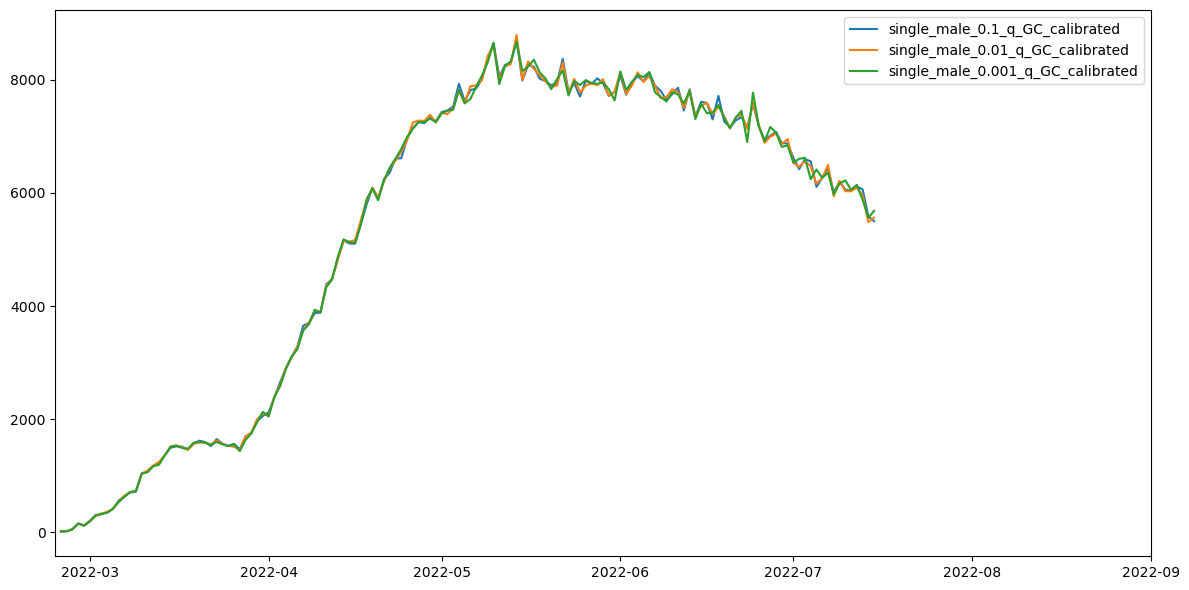

In [12]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,6))

for idx,df in enumerate(all_results):
    df['h_size'] = df[DEMO_TYPES].sum(axis=1)
    return_df = df.groupby('return_date')['h_size'].sum().reset_index()
    return_df['h_size'] = return_df['h_size'].rolling(1).mean()
    return_df = return_df.dropna(subset=['h_size'])
    #all_dfs.append(return_df)
    ax.plot(return_df['return_date'],return_df['h_size'],label=labels[idx])

# ax2 = ax.twinx()
# ax2.plot(local_impact_data_cnt['time'],local_impact_data_cnt['event_id'],label='local')
# ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['event_id'],label='global')
ax.set_xlim([pd.to_datetime('2022-02-23'),pd.to_datetime('2022-09-01')])
ax.legend(loc='best')
#ax2.legend(loc='lower right')
fig.tight_layout()

In [63]:
# labels[2] = 2

In [64]:
# labels[2] = 'gciw_q_0.0002_v_2'

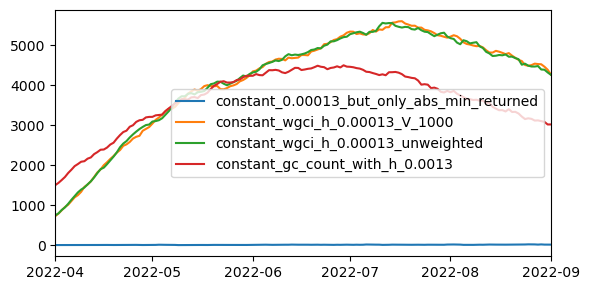

In [28]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(6,3))

for idx,df in enumerate(all_results):
    df['h_size'] = df[DEMO_TYPES].sum(axis=1)
    return_df = df.groupby('return_date')['h_size'].sum().reset_index()
    return_df['h_size'] = return_df['h_size'].rolling(5).mean()
    return_df = return_df.dropna(subset=['h_size'])
    #all_dfs.append(return_df)
    ax.plot(return_df['return_date'],return_df['h_size'],label=labels[idx])

# ax2 = ax.twinx()
# ax2.plot(local_impact_data_cnt['time'],local_impact_data_cnt['event_id'],label='local')
# ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['event_id'],label='global')
ax.set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-09-01')])
ax.legend(loc='best')
#ax2.legend(loc='lower right')
fig.tight_layout()

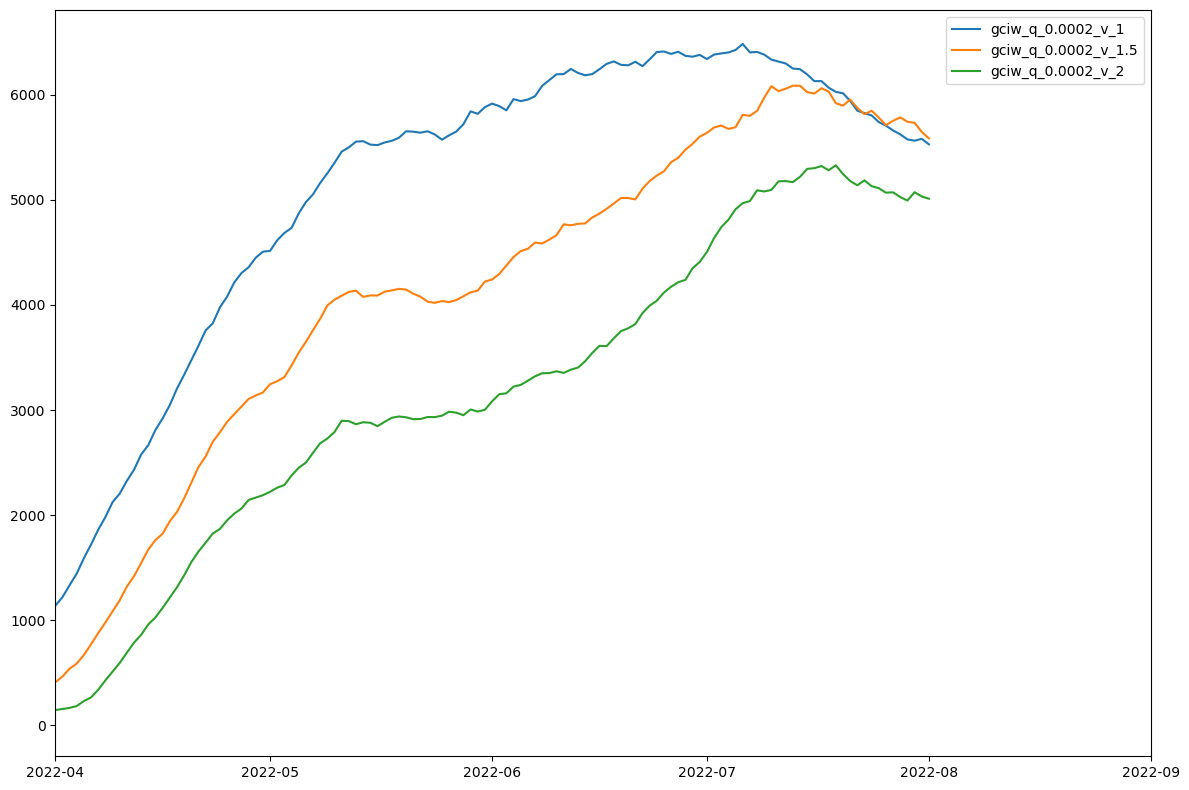

In [66]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,8))

for idx,df in enumerate(all_results):
    df['h_size'] = df[DEMO_TYPES].sum(axis=1)
    return_df = df.groupby('return_date')['h_size'].sum().reset_index()
    return_df['h_size'] = return_df['h_size'].rolling(5).mean()
    return_df = return_df.dropna(subset=['h_size'])
    #all_dfs.append(return_df)
    ax.plot(return_df['return_date'],return_df['h_size'],label=labels[idx])

# ax2 = ax.twinx()
# ax2.plot(local_impact_data_cnt['time'],local_impact_data_cnt['event_id'],label='local')
# ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['event_id'],label='global')
ax.set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-09-01')])
ax.legend(loc='best')
#ax2.legend(loc='lower right')
fig.tight_layout()

In [5]:
calibration_it = 1

functions = ['constant','constant_conflict','constant_global_conflict','constant_global_conflict_intensity','constant_global_conflict_weighted_intensity']

all_dfs = []

for f in functions:
    sim_idx = str(11).zfill(9)
    RETURN_DIR_NAME = f'RETURN_HAZARD_notebook_check_{f}_{str(calibration_it).zfill(9)}/'
    seed = 1 if (f=='constant_global_conflict' or f=='constant_global_conflict_weighted_intensity') else 0
    ff = OUTPUT_DIR+RETURN_DIR_NAME+f'mim_hid_return_Kyiv_SIM_{sim_idx}_SEED_{seed}.pq'
    df = pd.read_parquet(ff)
    df['h_size'] = df[DEMO_TYPES].sum(axis=1)
    df['return_date'] = pd.to_datetime(df['return_date'])
    return_df = df.groupby('return_date')['h_size'].sum().reset_index()
    return_df['h_size'] = return_df['h_size'].rolling(5).mean()
    return_df = return_df.dropna(subset=['h_size'])
    all_dfs.append(return_df)

In [6]:
total_impact_data['time'] = pd.to_datetime(total_impact_data['time'])
DAILY_MAX_EVENT_global = max((total_impact_data.groupby('time')['event_id'].count().reset_index())['event_id'])
total_impact_data_cnt = total_impact_data.groupby('time')['event_id'].count().reset_index()
total_impact_data_cnt['event_id'] = total_impact_data_cnt['event_id'].rolling(14).mean()
total_impact_data_cnt = total_impact_data_cnt.dropna(subset='event_id')
total_impact_data_cnt['event_id'] = total_impact_data_cnt['event_id']/DAILY_MAX_EVENT_global

local_impact_data = total_impact_data[total_impact_data.matching_place_id=='Kyiv']
DAILY_MAX_EVENT_local = max((local_impact_data.groupby('time')['event_id'].count().reset_index())['event_id'])
local_impact_data_cnt = local_impact_data.groupby('time')['event_id'].count().reset_index()
local_impact_data_cnt['event_id'] = local_impact_data_cnt['event_id'].rolling(14).mean()
local_impact_data_cnt = local_impact_data_cnt.dropna(subset='event_id')
local_impact_data_cnt['event_id'] = local_impact_data_cnt['event_id']/DAILY_MAX_EVENT_local



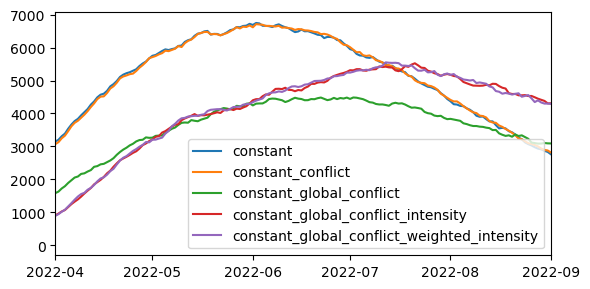

In [10]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(6,3))

for idx,f in enumerate(functions):
    ax.plot(all_dfs[idx]['return_date'],all_dfs[idx]['h_size'],label=f)

# ax2 = ax.twinx()
# ax2.plot(local_impact_data_cnt['time'],local_impact_data_cnt['event_id'],label='local')
# ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['event_id'],label='global')
ax.set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-09-01')])
ax.legend(loc='best')
#ax2.legend(loc='lower right')
fig.tight_layout()

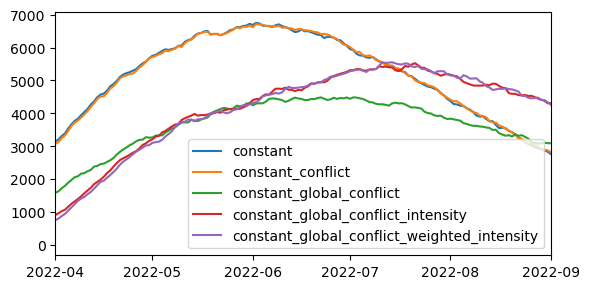

In [7]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(6,3))

for idx,f in enumerate(functions):
    ax.plot(all_dfs[idx]['return_date'],all_dfs[idx]['h_size'],label=f)

# ax2 = ax.twinx()
# ax2.plot(local_impact_data_cnt['time'],local_impact_data_cnt['event_id'],label='local')
# ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['event_id'],label='global')
ax.set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-09-01')])
ax.legend(loc='best')
#ax2.legend(loc='lower right')
fig.tight_layout()

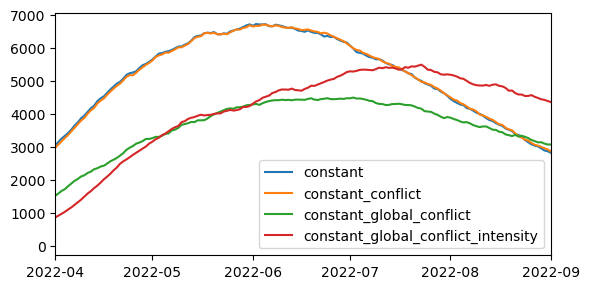

In [18]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(6,3))

for idx,f in enumerate(functions):
    ax.plot(all_dfs[idx]['return_date'],all_dfs[idx]['h_size'],label=f)

# ax2 = ax.twinx()
# ax2.plot(local_impact_data_cnt['time'],local_impact_data_cnt['event_id'],label='local')
# ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['event_id'],label='global')
ax.set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-09-01')])
ax.legend(loc='best')
#ax2.legend(loc='lower right')
fig.tight_layout()

In [26]:
import json

with open('/project/biocomplexity/UKR_forecast/migration_data/gtruth_from_various_source/slovak_border_movement.json', 'r') as file:
    data = json.load(file)

# Print the data
df = pd.DataFrame.from_dict(data['data']['timeseries'])
df['data_date'] = pd.to_datetime(df['data_date'])
df = df[df.data_date<=pd.to_datetime('2022-08-01')]
df['individuals'] = df['individuals'].rolling(15).mean()
df = df.dropna(subset='individuals')
svk_ukr_depart_df = df.copy()

#pl_border_data = pd.read_csv('/project/biocomplexity/UKR_forecast/migration_data/gtruth_from_various_source/poland_border_movement_utf8.csv',thousands=',')
pl_border_data = pd.read_csv('../../old_scripts/Diff_source_data_study/poland_border_movement_utf8.csv',thousands=',')
#ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset=['Total'])
pl_border_data['Date'] = pd.to_datetime(pl_border_data['Date'])
ukr_people_arrive_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Arrival to Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.sort_values(by='Date')

ukr_people_depart_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Departure from Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.sort_values(by='Date')

ukr_people_arrive_poland_by_date['Total'] = ukr_people_arrive_poland_by_date['Total'].rolling(15).mean()
ukr_people_depart_poland_by_date['Total'] = ukr_people_depart_poland_by_date['Total'].rolling(15).mean()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset='Total')
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.dropna(subset='Total')
ukr_people_arrive_poland_by_date =  ukr_people_arrive_poland_by_date.rename(columns={'Total':'Arrival'})
ukr_people_depart_poland_by_date =  ukr_people_depart_poland_by_date.rename(columns={'Total':'Depart'})


In [23]:
total_impact_data['time'].unique()

array(['2022-09-16', '2022-09-11', '2022-08-08', '2022-04-25',
       '2022-03-13', '2022-02-24', '2022-02-22', '2022-09-15',
       '2022-09-14', '2022-09-13', '2022-09-12', '2022-09-10',
       '2022-09-08', '2022-09-07', '2022-09-06', '2022-09-04',
       '2022-09-03', '2022-09-02', '2022-09-01', '2022-08-31',
       '2022-08-30', '2022-08-29', '2022-08-28', '2022-08-27',
       '2022-08-26', '2022-08-25', '2022-08-24', '2022-08-23',
       '2022-08-22', '2022-08-21', '2022-08-20', '2022-08-19',
       '2022-08-18', '2022-08-17', '2022-08-16', '2022-08-15',
       '2022-08-14', '2022-08-13', '2022-08-12', '2022-08-11',
       '2022-08-10', '2022-08-09', '2022-08-07', '2022-08-06',
       '2022-08-05', '2022-08-04', '2022-08-03', '2022-08-02',
       '2022-08-01', '2022-07-31', '2022-07-30', '2022-07-29',
       '2022-07-28', '2022-07-27', '2022-07-26', '2022-07-25',
       '2022-07-24', '2022-07-23', '2022-07-22', '2022-07-21',
       '2022-07-20', '2022-07-19', '2022-07-18', '2022-

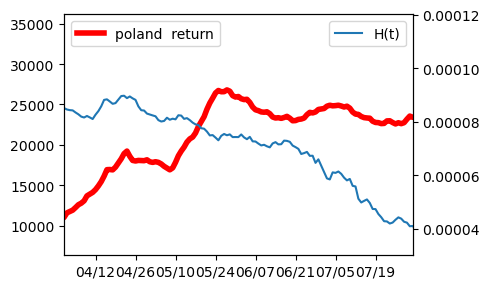

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig,ax = plt.subplots(figsize=(5,3))

total_impact_data['time'] = pd.to_datetime(total_impact_data['time'])
DAILY_MAX_EVENT_global = max((total_impact_data.groupby('time')['event_id'].count().reset_index())['event_id'])
total_impact_data_cnt = total_impact_data.groupby('time')['event_id'].count().reset_index()
total_impact_data_cnt['event_id'] = total_impact_data_cnt['event_id'].rolling(14).mean()
total_impact_data_cnt = total_impact_data_cnt.dropna(subset='event_id')
total_impact_data_cnt['event_id'] = total_impact_data_cnt['event_id']/DAILY_MAX_EVENT_global
total_impact_data_cnt['estimated_h_rate'] = (1-total_impact_data_cnt['event_id'])*Q_R
cnt_df = total_impact_data_cnt.copy()
ax.plot(ukr_people_depart_poland_by_date['Date'],ukr_people_depart_poland_by_date['Depart'],label='poland  return',color='red',linewidth=4)

ax2 = ax.twinx()
#ax2.plot(local_impact_data_cnt['time'],local_impact_data_cnt['event_id'],label='local')
total_impact_data_cnt['estimated_h_rate'] = (1-total_impact_data_cnt['event_id'])*Q_R

#ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['event_id'],label='C(t)')
ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['estimated_h_rate'],label='H(t)')

event_types = total_impact_data['event_type'].unique().tolist()

# for etype in event_types:
#     cur_impact_data = total_impact_data[total_impact_data.event_type==etype]
#     DAILY_MAX_EVENT = max((cur_impact_data.groupby('time')['event_id'].count().reset_index())['event_id'])
#     cur_impact_data_cnt = cur_impact_data.groupby('time')['event_id'].count().reset_index()
#     cur_impact_data_cnt['event_id'] = cur_impact_data_cnt['event_id'].rolling(14).mean()
#     cur_impact_data_cnt = cur_impact_data_cnt.dropna(subset='event_id')
#     cur_impact_data_cnt['event_id'] = cur_impact_data_cnt['event_id']/DAILY_MAX_EVENT
#     ax2.plot(cur_impact_data_cnt['time'],cur_impact_data_cnt['event_id'],label=etype)
    
ax.legend(loc='upper left')
ax2.legend(loc='best')

ax.set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-08-01')])

myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)

fig.tight_layout()

In [12]:
cnt_df

,time,event_id,estimated_h_rate
13,2022-02-14,0.110932,0.000116
14,2022-02-15,0.107947,0.000116
15,2022-02-16,0.111851,0.000115
16,2022-02-17,0.152733,0.000110
17,2022-02-18,0.200046,0.000104
...,...,...,...
223,2022-09-12,0.666514,0.000043
224,2022-09-13,0.657556,0.000045
225,2022-09-14,0.654800,0.000045
226,2022-09-15,0.644235,0.000046


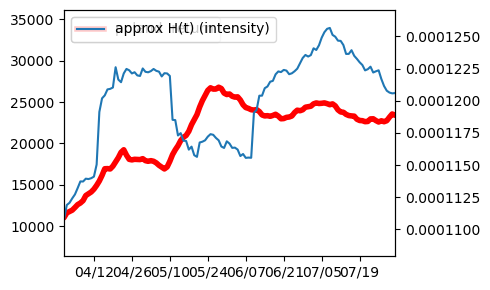

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig,ax = plt.subplots(figsize=(5,3))

total_impact_data['time'] = pd.to_datetime(total_impact_data['time'])
DAILY_MAX_EVENT_global = max((total_impact_data.groupby('time')['event_intensity'].sum().reset_index())['event_intensity'])
total_impact_data_cnt = total_impact_data.groupby('time')['event_intensity'].sum().reset_index()
total_impact_data_cnt['event_intensity'] = total_impact_data_cnt['event_intensity'].rolling(30).mean()
total_impact_data_cnt = total_impact_data_cnt.dropna(subset='event_intensity')
total_impact_data_cnt['event_intensity'] = total_impact_data_cnt['event_intensity']/DAILY_MAX_EVENT_global
#total_impact_data_cnt['event_cnt'] = total_impact_data_cnt.merge()
total_impact_data_cnt['estimated_h_rate'] = (1-total_impact_data_cnt['event_intensity'])*Q_R

ax.plot(ukr_people_depart_poland_by_date['Date'],ukr_people_depart_poland_by_date['Depart'],label='poland  return',color='red',linewidth=4)

ax2 = ax.twinx()
#ax2.plot(local_impact_data_cnt['time'],local_impact_data_cnt['event_id'],label='local')
#ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['event_intensity'],label='C(t) (intensity)')
ax2.plot(total_impact_data_cnt['time'],total_impact_data_cnt['estimated_h_rate'],label='approx H(t) (intensity)')

event_types = total_impact_data['event_type'].unique().tolist()

# for etype in event_types:
#     if 'Battle' in etype or 'Explosion' in etype:
#         cur_impact_data = total_impact_data[total_impact_data.event_type==etype]
#         DAILY_MAX_EVENT = max((cur_impact_data.groupby('time')['event_intensity'].sum().reset_index())['event_intensity'])
#         cur_impact_data_cnt = cur_impact_data.groupby('time')['event_intensity'].sum().reset_index()
#         cur_impact_data_cnt['event_intensity'] = cur_impact_data_cnt['event_intensity'].rolling(30).mean()
#         cur_impact_data_cnt = cur_impact_data_cnt.dropna(subset='event_intensity')
#         cur_impact_data_cnt['event_intensity'] = cur_impact_data_cnt['event_intensity']/DAILY_MAX_EVENT
#         ax2.plot(cur_impact_data_cnt['time'],cur_impact_data_cnt['event_intensity'],label=etype+' ')
    
ax.legend(loc='upper left')
ax2.legend(loc='best')

ax.set_xlim([pd.to_datetime('2022-04-01'),pd.to_datetime('2022-08-01')])

myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)

fig.tight_layout()

In [77]:
def get_ret_df(df):
    df['h_size'] = df[DEMO_TYPES].sum(axis=1)
    df['return_date'] = pd.to_datetime(df['return_date'])
    ret_df = df.groupby('return_date')['h_size'].sum().reset_index()
    ret_df['h_size'] = ret_df['h_size'].rolling(5).mean()
    ret_df = ret_df.dropna(subset=['h_size'])
    return ret_df

df1 = pd.read_parquet('/project/biocomplexity/UKR_forecast/migration_data/output_data_2024/RETURN_HAZARD_Bayesian_opt2_constant_global_conflict_weighted_intensity_000000001/mim_hid_return_Dniprovskyi_SIM_000000006_SEED_0.pq')
df2 = pd.read_parquet('/project/biocomplexity/UKR_forecast/migration_data/output_data_2024/RETURN_HAZARD_Bayesian_opt2_constant_global_conflict_intensity_000000001/mim_hid_return_Dniprovskyi_SIM_000000006_SEED_0.pq')
df3 = pd.read_parquet('/project/biocomplexity/UKR_forecast/migration_data/output_data_2024/RETURN_HAZARD_Bayesian_opt2_constant_000000001/mim_hid_return_Dniprovskyi_SIM_000000006_SEED_0.pq')


In [78]:
ret_df1 = get_ret_df(df1)
ret_df2 = get_ret_df(df2)
ret_df3 = get_ret_df(df3)

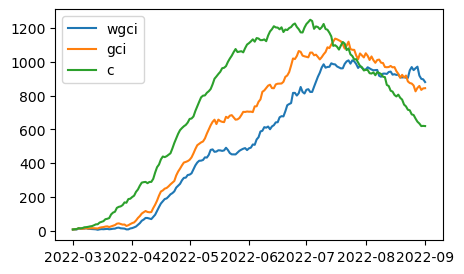

In [79]:
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(ret_df1['return_date'],ret_df1['h_size'],label='wgci')
ax.plot(ret_df2['return_date'],ret_df2['h_size'],label='gci')
ax.plot(ret_df3['return_date'],ret_df3['h_size'],label='c')

ax.legend(loc='best')

In [72]:
ret_df2

,return_date,h_size
0,2022-02-25,2
1,2022-02-26,10
2,2022-02-27,4
3,2022-02-28,14
4,2022-03-01,13
...,...,...
184,2022-08-28,842
185,2022-08-29,885
186,2022-08-30,814
187,2022-08-31,882


In [73]:
ret_df3

,return_date,h_size
0,2022-02-25,2
1,2022-02-26,10
2,2022-02-27,4
3,2022-02-28,14
4,2022-03-01,13
...,...,...
184,2022-08-28,634
185,2022-08-29,646
186,2022-08-30,585
187,2022-08-31,632
